In [1]:
import os
import trodes_data_parse as tdp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


expDir = 'experiments'
folderName = '20180907_132227'
atimeFile =  expDir + '/%s/%s.analog/%s.timestamps.dat' % (folderName, folderName, folderName)
dInFile = expDir + '/%s/%s.DIO/%s.dio_Din1.dat' % (folderName, folderName, folderName)
dOutFile = expDir + '/%s/%s.DIO/%s.dio_Dout1.dat' % (folderName, folderName, folderName)

atimeData = tdp.readTrodesExtractedDataFile(atimeFile)['data']
dIn1Data = tdp.readTrodesExtractedDataFile(dInFile)
dInArray = dIn1Data['data']
dInSamp = np.int_(dIn1Data['clockrate'])
dOutArray = tdp.readTrodesExtractedDataFile(dOutFile)['data']

In [2]:
def dfPruner(dfArray):
    df = pd.DataFrame(dfArray)
    df['new_time'] = df['time'] - offset
    df['shif_time'] = df['new_time'].shift(-1)
    #set last value to final time
    df.iloc[-1,df.columns.get_loc('shif_time')] = restrucTime[-1]
    #Drop first and last row
    df = df[1:-1]
    return df
def stateVecProd(dInS, df):
    stateVec = np.zeros(np.size(restrucTime))
    #start from 0
    currIndex = 0
    for index, row in df.iterrows():
        stateVec[currIndex: int(row['shif_time'])] = row['state']
        currIndex = int(row['shif_time'])
    return stateVec

(array([  1.,   0.,   0.,   0.,   0.,   0., 181., 639., 176.,   2.]),
 array([4.76666667, 4.79666667, 4.82666667, 4.85666667, 4.88666667,
        4.91666667, 4.94666667, 4.97666667, 5.00666667, 5.03666667,
        5.06666667]),
 <a list of 10 Patch objects>)

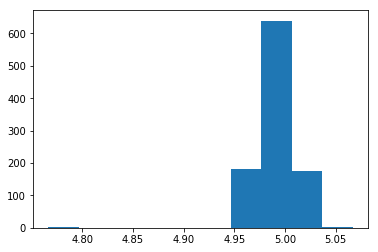

In [3]:
#Convert to an array of integer primitives from aTimeData
restrucTime = np.array([i[0] for i in atimeData])
#remove offset to zero index Time
offset = restrucTime[0]
restrucTime = restrucTime - offset

dIndf = dfPruner(dInArray)

#Just High-to-low State transitions
dHighLow = dIndf[dIndf['state'] == 0]
#Histogram of points between each trigger pulses, should have same num of data points
# as num of trigger pulses sent by ECU
plt.hist((dHighLow.diff()/30.0)['new_time'].dropna())


(array([398.,   0.,   0.,   0.,   0., 601.,   0.,   0.,   0.,   1.]),
 array([3.93333333, 3.94      , 3.94666667, 3.95333333, 3.96      ,
        3.96666667, 3.97333333, 3.98      , 3.98666667, 3.99333333,
        4.        ]),
 <a list of 10 Patch objects>)

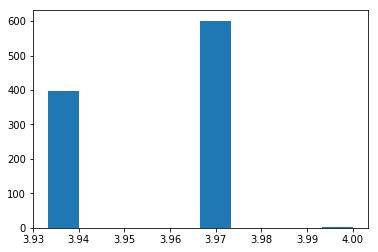

In [4]:
#Histogram of How long exposure is 
downLow = dHighLow['shif_time'] - dHighLow['new_time']
plt.hist(downLow/30.0)

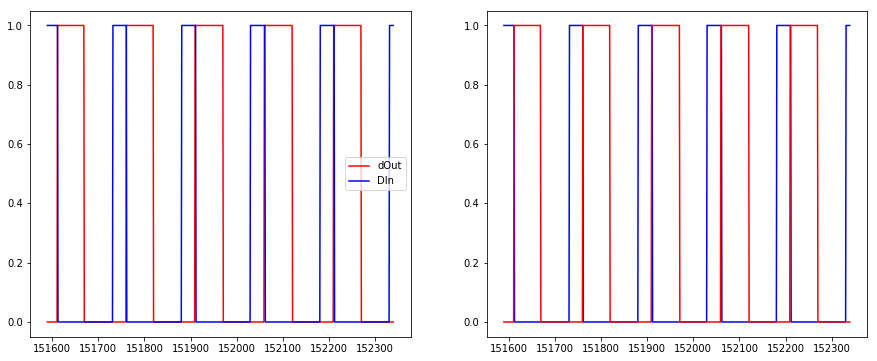

In [16]:
#Time Series Visualizations of dIn1 and dOut1

dOutdf = dfPruner(dOutArray)
examTime = .025 # Time interval length in seconds
startTime = 151590 #Beginning of Time interval you'd like to examine in clock cycles. Make
#sure it's past the first new_time
endTime = startTime + int(round(examTime*dInSamp))

dOutStateVec = stateVecProd(dInSamp, dOutdf)
dInStateVec = stateVecProd(dInSamp, dIndf)

#Get times for each down point
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(restrucTime[startTime:endTime], dOutStateVec[startTime:endTime], 'r', label = "dOut")
plt.plot(restrucTime[startTime:endTime], dInStateVec[startTime:endTime], 'b', label = 'DIn')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(restrucTime[startTime:endTime], dInStateVec[startTime:endTime], 'b', label = 'DIn')
plt.plot(restrucTime[startTime:endTime], dOutStateVec[startTime:endTime], 'r', label = "dOut")
plt.show()

(array([  1.,   0.,   0.,   0.,   0., 234.,   0.,   0.,   0., 765.]),
 array([0.        , 0.00666667, 0.01333333, 0.02      , 0.02666667,
        0.03333333, 0.04      , 0.04666667, 0.05333333, 0.06      ,
        0.06666667]),
 <a list of 10 Patch objects>)

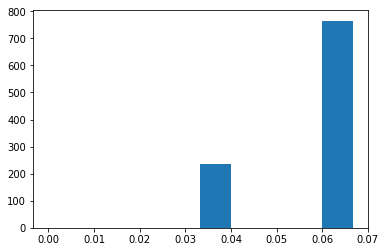

In [60]:
#Histogram of delays from dInHightoLow to dOutLowtoHigh
dInHtoL = dIndf[dIndf['state'] == 0]['new_time']
dOutLtoH = dOutdf[dOutdf['state'] == 1]['new_time']
delay = (dInHtoL- dOutLtoH)/30.0
plt.hist(delay)